In [8]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')


In [9]:
# Séparation des colonnes numériques et catégorielles
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Remplacement des valeurs manquantes
df[numerical_cols] = df[numerical_cols].fillna(0.0)
df[categorical_cols] = df[categorical_cols].fillna('NA')


In [10]:
from sklearn.model_selection import train_test_split

# Cible
y = df['converted']
X = df.drop(columns=['converted'])

# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2


In [11]:
from sklearn.metrics import roc_auc_score

# Variables à tester
variables = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Calcul des AUC
auc_results = {}
for var in variables:
    score = X_train[var]
    auc = roc_auc_score(y_train, score)
    # Inversion si AUC < 0.5
    if auc < 0.5:
        score = -score
        auc = roc_auc_score(y_train, score)
    auc_results[var] = auc

# Affichage des résultats
sorted_auc = sorted(auc_results.items(), key=lambda x: x[1], reverse=True)
for var, auc in sorted_auc:
    print(f"{var}: AUC = {auc:.4f}")


number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
lead_score: AUC = 0.6145
annual_income: AUC = 0.5520


In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Fusion X_train et y_train
df_train_full = X_train.copy()
df_train_full['converted'] = y_train

df_val_full = X_val.copy()
df_val_full['converted'] = y_val

# Conversion en dictionnaire
train_dict = df_train_full.drop(columns=['converted']).to_dict(orient='records')
val_dict = df_val_full.drop(columns=['converted']).to_dict(orient='records')

# Encodage
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)


In [13]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [14]:
y_pred_val = model.predict_proba(X_val_encoded)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)
print(f"AUC sur validation : {auc_val:.3f}")


AUC sur validation : 0.817


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


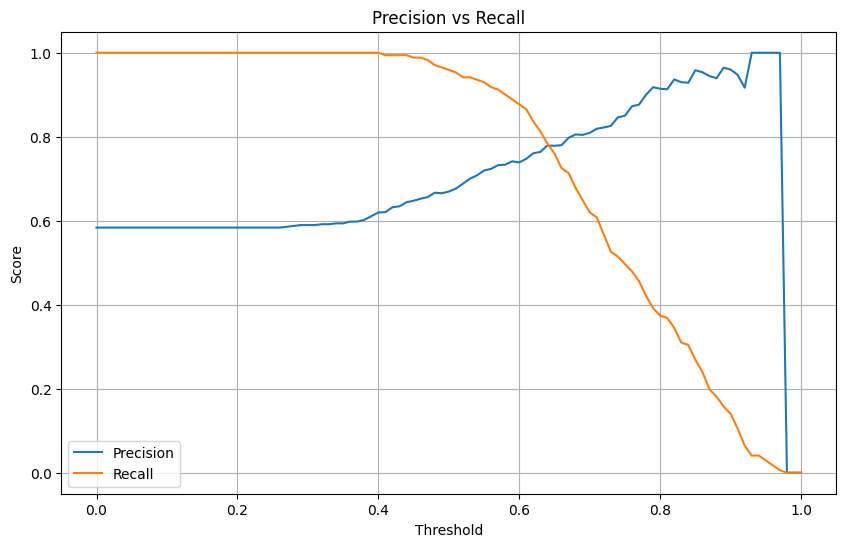

In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred_val >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))

# Tracé des courbes
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Calcul de la différence absolue
diffs = np.abs(np.array(precisions) - np.array(recalls))
intersection_index = np.argmin(diffs)
intersection_threshold = thresholds[intersection_index]
print(f"Intersection à : {intersection_threshold:.3f}")


Intersection à : 0.980


In [17]:
f1_scores = []

for p, r in zip(precisions, recalls):
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

# Trouver le seuil avec le F1 maximal
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
print(f"Seuil optimal F1 : {best_threshold:.3f}")


Seuil optimal F1 : 0.570


In [18]:

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
import numpy as np

# Fusion des données train + val
df_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])


In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)


In [20]:
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx]
    y_train_cv = y_full_train.iloc[train_idx]
    
    df_val_cv = df_full_train.iloc[val_idx]
    y_val_cv = y_full_train.iloc[val_idx]
    
    # Encodage avec DictVectorizer
    train_dict = df_train_cv.to_dict(orient='records')
    val_dict = df_val_cv.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train_cv = dv.fit_transform(train_dict)
    X_val_cv = dv.transform(val_dict)
    
    # Entraînement du modèle
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_cv, y_train_cv)
    
    # Prédiction et AUC
    y_pred_cv = model.predict_proba(X_val_cv)[:, 1]
    auc = roc_auc_score(y_val_cv, y_pred_cv)
    auc_scores.append(auc)

# Écart-type des scores
std_auc = np.std(auc_scores)
print(f"Écart-type des AUC : {std_auc:.4f}")


Écart-type des AUC : 0.0183


In [21]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Paramètres
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)


In [22]:
for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        y_train_cv = y_full_train.iloc[train_idx]
        
        df_val_cv = df_full_train.iloc[val_idx]
        y_val_cv = y_full_train.iloc[val_idx]
        
        # Encodage
        train_dict = df_train_cv.to_dict(orient='records')
        val_dict = df_val_cv.to_dict(orient='records')
        
        dv = DictVectorizer(sparse=False)
        X_train_cv = dv.fit_transform(train_dict)
        X_val_cv = dv.transform(val_dict)
        
        # Modèle
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_cv, y_train_cv)
        
        y_pred_cv = model.predict_proba(X_val_cv)[:, 1]
        auc = roc_auc_score(y_val_cv, y_pred_cv)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"C={C}: Mean AUC={mean_auc:.3f}, Std={std_auc:.3f}")


C=1e-06: Mean AUC=0.561, Std=0.043
C=0.001: Mean AUC=0.867, Std=0.015
C=1: Mean AUC=0.822, Std=0.018
